## Exploratory data analysis

### 1. Import libraries

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import re
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### 2. Load dataset

In [2]:
train_data = pd.read_csv("../data/train_E6oV3lV.csv")
test_data = pd.read_csv('../data/test_tweets_anuFYb8.csv')

train = train_data.copy()
train_data['label'] = train_data['label'].astype('category')
train_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
def clean_text(text): # Remove URLs & mentions
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    return text

def expand_contractions(text): # Expand contractions in text processing
    expanded_words = []
    for tx in text.split():
        #if tx != contractions.fix(tx): print(tx, contractions.fix(tx))
        expanded_words.append(contractions.fix(tx))
    new_text = ' '.join(expanded_words)
    return new_text

def remove_non_alpha(new_text):  # Extract only alphabets
    new_text = re.sub(r'[^a-zA-Z0-9\s]', '', new_text.lower())
    return new_text

def remove_stopwords(new_text): # Removing Stopwords
    stop_words = set(stopwords.words('english'))
    return " ".join(token for token in new_text.split() if token not in stop_words)

def word_lemma(new_text): # Remmatizer
    return " ".join([WordNetLemmatizer().lemmatize(token) for token in new_text.split()])

def tokenizer(new_text):
    return [token for token in new_text.split()]

def drop_column(df, column): # Drop column
    df = df.drop([column], axis=1)
    return df

for df in [train_data, test_data]:
    df['tweet'] = df['tweet'].apply(clean_text)
    df['tweet'] = df['tweet'].apply(expand_contractions)
    df['tweet'] = df['tweet'].apply(remove_non_alpha)
    df['features'] = df['tweet'].apply(remove_stopwords)
    df['features'] = df['features'].apply(word_lemma)
    df['tokens'] = df['features'].apply(tokenizer)


In [4]:
# oversampling
label_0 = train_data[train_data['label'] == 0] # label counting
label_1 = train_data[train_data['label'] == 1]

oversample = label_1.sample(len(label_0), replace=True, random_state=123)
train_oversampled = pd.concat([oversample, label_0], axis=0)
train_oversampled = train_oversampled.sample(frac = 1)
print(train_oversampled['label'].value_counts())
train_oversampled

label
0    29720
1    29720
Name: count, dtype: int64


,id,label,tweet,features,tokens
6911,6912,0,officially 18 birthday to me,officially 18 birthday,"[officially, 18, birthday]"
17500,17501,0,51 is hardly a ringing rebuke of,51 hardly ringing rebuke,"[51, hardly, ringing, rebuke]"
3643,3644,0,the sellers accepted my offer and the process ...,seller accepted offer process begin,"[seller, accepted, offer, process, begin]"
11220,11221,1,sikh temple vandalised in in calgary wso conde...,sikh temple vandalised calgary wso condemns act,"[sikh, temple, vandalised, calgary, wso, conde..."
8897,8898,1,trump is guilty of treason we theresistance m...,trump guilty treason theresistance must resist...,"[trump, guilty, treason, theresistance, must, ..."
...,...,...,...,...,...
6021,6022,1,in trumpsamerica feeling empowerd fowoh mothe...,trumpsamerica feeling empowerd fowoh mother ar...,"[trumpsamerica, feeling, empowerd, fowoh, moth..."
7969,7970,0,aww yeah it is all good bing bong bing bong,aww yeah good bing bong bing bong,"[aww, yeah, good, bing, bong, bing, bong]"
14893,14894,1,vandals turned a jewish familys menorah into a...,vandal turned jewish family menorah swastika a...,"[vandal, turned, jewish, family, menorah, swas..."
26523,26524,0,i am thankful for fall leaves thankful positive,thankful fall leaf thankful positive,"[thankful, fall, leaf, thankful, positive]"


## Model Building

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, PrecisionRecallDisplay
from sklearn.pipeline import make_pipeline

In [6]:
# splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_oversampled['features'], train_oversampled['label'], test_size=0.2, random_state=123)

In [7]:
# set up models and test them
test_model = [MultinomialNB(), RandomForestClassifier(), DecisionTreeClassifier(), 
              LogisticRegression(solver='saga'), SVC(), KNeighborsClassifier(), SGDClassifier(), XGBClassifier()]

ALL_Cases_results = pd.DataFrame()
file = pd.DataFrame()

for val in test_model:
    # Feature extraction using TF-IDF
    # Choose a model from list
    pipe = make_pipeline(TfidfVectorizer(), val)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    model = list(pipe.named_steps)
    result = classification_report(y_pred, y_val, output_dict=True)
    df_results = pd.DataFrame(result)
    df_results['model'] = model[1]
    file = pd.concat([file, df_results], axis=0)
    total_result6 = file

ALL_Cases_results = pd.concat([ALL_Cases_results, file[file.index == 'f1-score']], axis=0)
# f1-scores for 8 models
ALL_Cases_results

,0,1,accuracy,macro avg,weighted avg,model
f1-score,0.953144,0.956239,0.954744,0.954691,0.954792,multinomialnb
f1-score,0.981437,0.982208,0.981830,0.981822,0.981837,randomforestclassifier
f1-score,0.946114,0.951636,0.949024,0.948875,0.949164,decisiontreeclassifier
f1-score,0.973844,0.974825,0.974344,0.974335,0.974352,logisticregression
f1-score,0.994827,0.994910,0.994869,0.994868,0.994869,svc
f1-score,0.420056,0.732813,0.634169,0.576435,0.691377,kneighborsclassifier
f1-score,0.970075,0.971026,0.970559,0.970551,0.970565,sgdclassifier
f1-score,0.913792,0.908207,0.911087,0.910999,0.911184,xgbclassifier


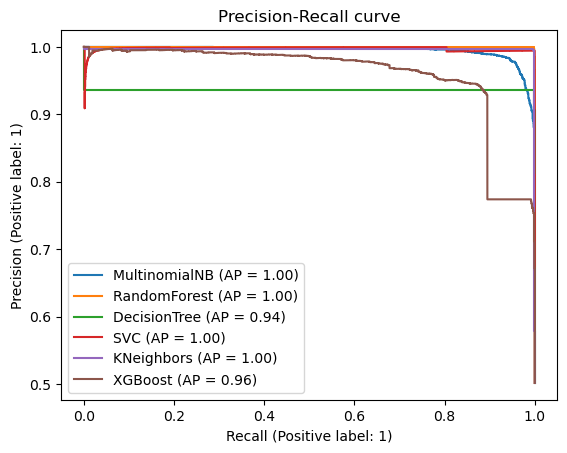

In [11]:
# precision-recall curves for 6 models
test_model = [MultinomialNB(), RandomForestClassifier(), DecisionTreeClassifier(),
              SVC(), KNeighborsClassifier(), XGBClassifier()]
models = ['MultinomialNB', 'RandomForest', 'DecisionTree', 'SVC', 'KNeighbors', 'XGBoost']

for idx, val in enumerate(test_model):
    pipe = make_pipeline(TfidfVectorizer(), val)
    pipe.fit(X_train, y_train)
    PrecisionRecallDisplay.from_estimator(pipe, X_val, y_val, ax=plt.gca(), name=models[idx])

plt.title('Precision-Recall curve')
plt.show()

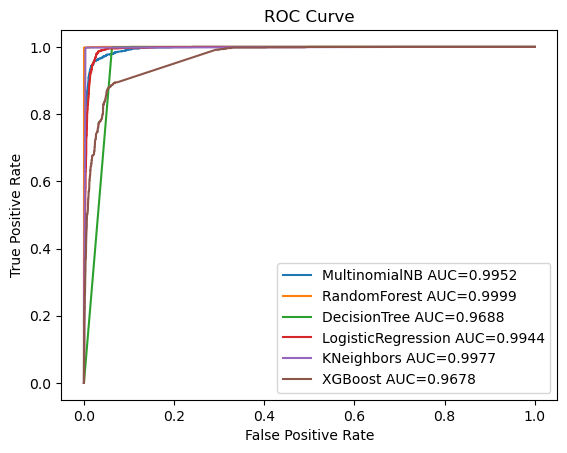

In [9]:
# ROC scores and curves for 6 models
test_model = [MultinomialNB(), RandomForestClassifier(), DecisionTreeClassifier(),
              LogisticRegression(solver='saga'), KNeighborsClassifier(), XGBClassifier()]
models = ['MultinomialNB', 'RandomForest', 'DecisionTree', 'LogisticRegression', 'KNeighbors', 'XGBoost']

for idx, val in enumerate(test_model):
    pipe = make_pipeline(TfidfVectorizer(), val)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict_proba(X_val)
    y_pred = y_pred[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    auc = round(roc_auc_score(y_val, y_pred), 4)
    plt.plot(fpr, tpr, label=models[idx]+' AUC='+str(auc))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()